In [1]:
import h5py
import tensorflow as tf
from keras import layers, models
import numpy as np


c:\Users\Raaghav\miniconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
file = h5py.File("../data/Dataset_Specific_labelled.h5", "r")
X_ds = file["jet"]
Y_ds = file["Y"]

num_samples = len(Y_ds)
indices = np.arange(num_samples)

np.random.seed(42)
np.random.shuffle(indices)

split = int(0.8 * num_samples)
train_idx = indices[:split]
test_idx  = indices[split:]


In [3]:
def gen_labelled(indices):
    for i in indices:
        x = X_ds[i].astype("float16")   # memory efficient
        y = int(Y_ds[i])               # scalar label
        yield x, y

In [4]:
train_ds = tf.data.Dataset.from_generator(
    lambda: gen_labelled(train_idx),
    output_signature=(
        tf.TensorSpec(shape=(125, 125, 8), dtype=tf.float16),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

train_ds = train_ds.shuffle(512).batch(8).prefetch(tf.data.AUTOTUNE)


In [5]:
test_ds = tf.data.Dataset.from_generator(
    lambda: gen_labelled(test_idx),
    output_signature=(
        tf.TensorSpec(shape=(125, 125, 8), dtype=tf.float16),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)


In [6]:
def res_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, 3, stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)


In [7]:
def resnet_clf(input_shape=(125,125,8)):
    inputs = layers.Input(shape=(125, 125, 8))
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = res_block(x, 64)
    x = res_block(x, 64)
    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)
    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1,activation = 'sigmoid', name = 'cf')(x)
    return tf.keras.Model(inputs, outputs, name="resnet15_clf")


In [8]:
clf_model_scratch = resnet_clf(input_shape=(125,125,8))
clf_model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)


In [9]:
history_clf = clf_model_scratch.fit(
    train_ds,
    epochs=10,
    batch_size=128)


Epoch 1/10


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1000/1000 [==============================] - 204s 14ms/step - loss: 0.3973 - auc: 0.9033
Epoch 2/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.3180 - auc: 0.9387
Epoch 3/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.2912 - auc: 0.9481
Epoch 4/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.2616 - auc: 0.9575
Epoch 5/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.2400 - auc: 0.9644
Epoch 6/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.1996 - auc: 0.9750
Epoch 7/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.1576 - auc: 0.9844
Epoch 8/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.1285 - auc: 0.9892
Epoch 9/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0999 - auc: 0.9936
Epoch 10/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0666 - auc: 0.9970


In [10]:
def resnet_reg(input_shape=(125,125,8)):
    inputs = layers.Input(shape=(125, 125, 8))
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = res_block(x, 64)
    x = res_block(x, 64)
    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)
    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1,name = 'rf')(x)
    return tf.keras.Model(inputs, outputs, name="resnet15_reg")


In [11]:
reg_model_scratch = resnet_reg(input_shape=(125,125,8))

In [12]:
reg_model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

reg_model_scratch.fit(
    train_ds,
    epochs=10
)


Epoch 1/10


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1000/1000 [==============================] - 15s 13ms/step - loss: 0.1609 - mae: 0.3247
Epoch 2/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.1019 - mae: 0.2440
Epoch 3/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0762 - mae: 0.2115
Epoch 4/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0473 - mae: 0.1698
Epoch 5/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0321 - mae: 0.1422
Epoch 6/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0245 - mae: 0.1236
Epoch 7/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0207 - mae: 0.1141
Epoch 8/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0192 - mae: 0.1097
Epoch 9/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0187 - mae: 0.1080
Epoch 10/10
1000/1000 [==============================] - 14s 13ms/step - loss: 0.0164 - mae: 0.1017


In [13]:
clf_model_scratch.save("../models/classification_scratch.h5")

In [14]:
reg_model_scratch.save("../models/regression_scratch.h5")

In [15]:
clf_model_scratch.predict(test_ds)

     17/Unknown - 0s 10ms/step

C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


250/250 [==============================] - 3s 11ms/step


array([[0.99990714],
       [0.00315231],
       [0.9998124 ],
       ...,
       [0.00190655],
       [0.04941313],
       [0.04120717]], dtype=float32)

In [16]:
reg_model_scratch.predict(test_ds)

     30/Unknown - 0s 5ms/step

C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


250/250 [==============================] - 1s 5ms/step


array([[1.0910107 ],
       [0.2651034 ],
       [1.1117471 ],
       ...,
       [0.2554693 ],
       [0.33362514],
       [0.6339444 ]], dtype=float32)

In [17]:
from sklearn.metrics import roc_curve, auc

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(clf_model_scratch.predict(x).ravel())

fpr_scratch, tpr_scratch, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr_scratch, tpr_scratch)


1/1 [==============================] - 0s 115ms/step


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1/1 [==============================] - 0s 17ms/step


In [18]:
import matplotlib.pyplot as plt

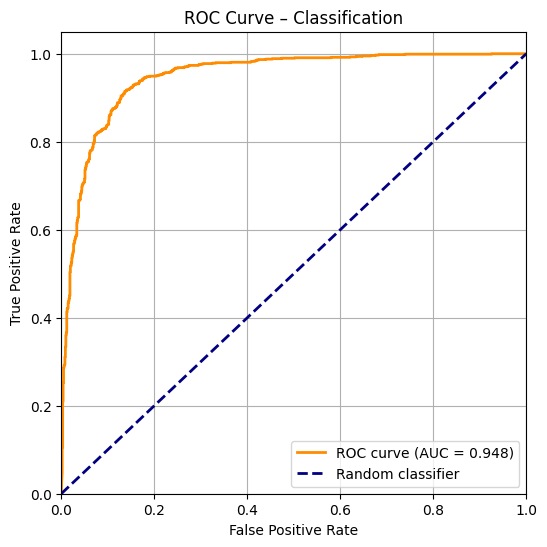

In [19]:
plt.figure(figsize=(6,6))
plt.plot(fpr_scratch, tpr_scratch, color="darkorange",
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 15ms/step


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_796\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'True vs Predicted')

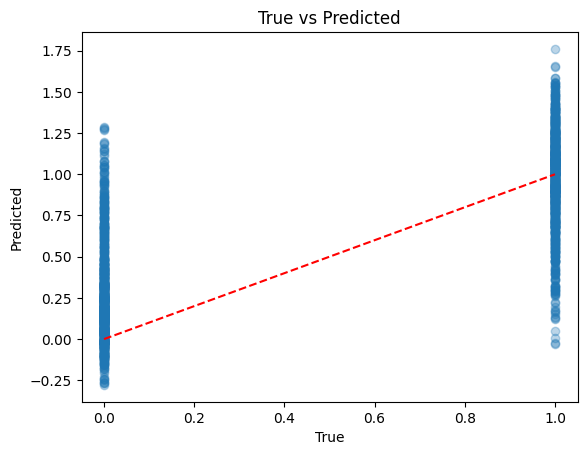

In [20]:
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(reg_model_scratch.predict(x).ravel())

plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted")


In [21]:
clf_model_scratch.summary()

Model: "resnet15_clf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 64)   25088       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [22]:
reg_model_scratch.summary()

Model: "resnet15_reg"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 125, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 63, 63, 64)   25088       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 63, 63, 64)  256         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                       